# Data Cleaning

Exclusion critera:
1. Don't use social media
2. Was aware of one of the rumours
3. Failed either attention check
2. An outlier in completion time (>3 std devs below the mean)


## Get data from Azure

In [1]:
from pymongo import MongoClient
from secret import URI
import json
client = MongoClient(URI)
db = client["thesis-db"]

In [2]:
import pandas as pd
import numpy as np
participants = pd.DataFrame.from_records(list(db["participants"].find()))
num_participants = len(participants["PROLIFIC_PID"].unique())
dummies = ["gender","affiliatedMovements","socialMedias"]
for col in dummies:
    participants = participants.explode(col)
participants = pd.get_dummies(participants,columns=dummies).max(level=0)
assert len(participants) == num_participants, "Number of participants changed"
num_participants = len(participants["PROLIFIC_PID"].unique())
print(f"Original number of participants: {num_participants}")

Original number of participants: 11


In [3]:
to_drop = pd.Series(None,name="PROLIFIC_PID",dtype=str)

### 1. Drop participants who don't use social media

In [4]:
sm_cols = [c for c in participants.columns if "socialMedias" in c and not "none" in c]
# TO TEST: Uncomment the "none" category to see if there is anyone who ticked it
no_sm = (participants[sm_cols] == 0).T.all()#| participants["socialMedias_none"].astype(bool))
no_sm = pd.Series(participants[no_sm]["PROLIFIC_PID"].unique())
to_drop = pd.Series(to_drop.append(no_sm))
num_no_sm = len(no_sm)
num_participants -= num_no_sm
print(f"{num_no_sm} don't have social media, {num_participants} remaining participants.")

0 don't have social media, 11 remaining participants.


### 2. Drop participants who were aware of either rumour

In [5]:
mappings = {
    "pass": True,
    "fail": False,
    "true": True,
    "false": False
}

In [6]:
r1_check = pd.DataFrame.from_records(list(db["rumour-one-check"].find()))
r2_check = pd.DataFrame.from_records(list(db["rumour-two-check"].find()))
rumour_check = r1_check.merge(r2_check,
                              left_on="PROLIFIC_PID",
                              right_on="PROLIFIC_PID",
                              suffixes=("R1","R2"),
                              how="left")
for col in list(["awareR1","awareR2","attentionCheckR1","attentionCheckR2"]):
      rumour_check[col] = rumour_check[col].map(mappings)
assert len(rumour_check) == len(participants), "Dataframes have different row lengths"
aware = rumour_check["awareR1"].astype(bool) | rumour_check["awareR2"].astype(bool)
aware = pd.Series(rumour_check[aware]["PROLIFIC_PID"].unique())
to_drop = pd.Series(to_drop.append(aware))
num_aware = len(aware)
num_participants -= num_aware
print(f"{num_aware} aware of a rumour, {num_participants} remaining participants.")

2 aware of a rumour, 9 remaining participants.


### 3. Drop participants who failed either attention check

In [7]:
no_attention = ~(rumour_check["attentionCheckR1"].astype(bool) & rumour_check["attentionCheckR2"].astype(bool))
no_attention = pd.Series(rumour_check[no_attention]["PROLIFIC_PID"].unique())
to_drop = pd.Series(to_drop.append(no_attention))
num_no_attention = len(no_attention)
num_participants -= num_no_attention
print(f"{num_no_attention} failed attention check, {num_participants} remaining participants.")

0 failed attention check, 9 remaining participants.


### 4. Drop participants who were outliers in the amount of time taken

Outlier: participants who the amount of time taken is more than 3 standard deviations below the mean 
- not above as we put a time cap on the time taken

In [8]:
r1_posts = pd.DataFrame.from_records(list(db["rumour-one-results"].find()))
r1_posts = r1_posts.explode("posts")
r1_posts = pd.concat([r1_posts.drop(['posts'], axis=1), r1_posts['posts'].apply(pd.Series)], axis=1)

r2_posts = pd.DataFrame.from_records(list(db["rumour-two-results"].find()))
r2_posts = r2_posts.explode("posts")
r2_posts = pd.concat([r2_posts.drop(['posts'], axis=1), r2_posts['posts'].apply(pd.Series)], axis=1)
posts = pd.concat([r1_posts,r2_posts])
assert (posts.groupby("PROLIFIC_PID").count()["id"] == 56).all(), "Some people have a different number of posts"

<AxesSubplot:ylabel='Frequency'>

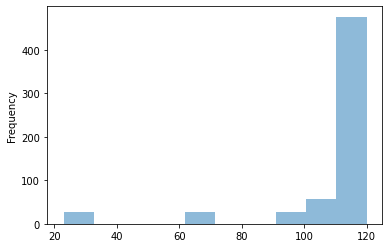

In [9]:
from scipy.stats import zscore
posts.secondsTaken.plot.hist(alpha=0.5)
z_scores = zscore(posts["secondsTaken"])
outliers = posts[z_scores < -3]
outliers.secondsTaken.plot.hist(alpha=0.5)

In [10]:
print(outliers[["PROLIFIC_PID","secondsTaken"]].drop_duplicates())
drop = input("Drop these? (YES/NO)")
if drop == "YES":
    outliers = pd.Series(outliers["PROLIFIC_PID"].unique())
    num_outliers = len(outliers)
    to_drop = pd.Series(to_drop.append(outliers))
    num_participants -= num_outliers
    print(f"{num_outliers} outlier(s) in completion time, {num_participants-num_outliers} remaining participants.")
else:
    print(f"Not dropping. {num_participants} remaining participants.")

               PROLIFIC_PID  secondsTaken
2  60a8bc614a7de0fb24b5f91f            23


Drop these? (YES/NO) YES


1 outlier(s) in completion time, 7 remaining participants.


### Post study questionairre

In [11]:
post_study = pd.DataFrame.from_records(list(db["post-study-responses"].find()))
print("{}x{}".format(*post_study.shape))

11x11


#### Data type conversions

In [12]:
participants["timeSubmitted"] = pd.to_datetime(participants["timeSubmitted"], infer_datetime_format=True)  
participants["age"] = participants["age"].astype(int)
participants["attendsProtests"] = participants["attendsProtests"].map(mappings)
posts["timeSubmitted"] = pd.to_datetime(posts["timeSubmitted"], infer_datetime_format=True)  
posts["id"] = posts["id"].astype(int)
rumour_check["timeSubmittedR1"] = pd.to_datetime(rumour_check["timeSubmittedR1"], infer_datetime_format=True)  
rumour_check["timeSubmittedR2"] = pd.to_datetime(rumour_check["timeSubmittedR2"], infer_datetime_format=True) 
post_study["veracityR1"] = post_study["veracityR1"].astype(float)
post_study["veracityR2"] = post_study["veracityR2"].astype(float)

#### Drop uneccessary columns

In [13]:
study_id = participants.loc[1,"STUDY_ID"]
print(study_id)

607d6b3929befce813fe5ba2


In [14]:
print(participants.columns)
participants.drop(['_id', 'SESSION_ID', 'STUDY_ID'],axis=1,inplace=True)

rumour_check = rumour_check[["PROLIFIC_PID",
                             "timeSubmittedR1",
                             "timeSubmittedR2",
                             "awareR1",
                             "awareR2",
                             "attentionCheckR1",
                             "attentionCheckR2"]]

print(posts.columns)
posts.drop(['_id', 'SESSION_ID', 'STUDY_ID'],axis=1,inplace=True)

print(post_study.columns)
post_study.drop(['_id', 'SESSION_ID', 'STUDY_ID'],axis=1,inplace=True)

Index(['_id', 'PROLIFIC_PID', 'SESSION_ID', 'STUDY_ID', 'consent',
       'timeSubmitted', 'educationLevel', 'attendsProtests',
       'politicalAffiliation', 'age', 'gender_man', 'gender_woman',
       'affiliatedMovements_climate', 'affiliatedMovements_freeSpeech',
       'affiliatedMovements_gender', 'affiliatedMovements_indigenous',
       'affiliatedMovements_labour', 'affiliatedMovements_lgbtqa',
       'affiliatedMovements_race', 'affiliatedMovements_religion',
       'affiliatedMovements_smallGov', 'socialMedias_None',
       'socialMedias_facebook', 'socialMedias_instagram',
       'socialMedias_reddit', 'socialMedias_snapchat', 'socialMedias_tiktok',
       'socialMedias_twitter'],
      dtype='object')
Index(['_id', 'PROLIFIC_PID', 'SESSION_ID', 'STUDY_ID', 'condition',
       'timeSubmitted', 'secondsTaken', 'id', 'rumour', 'code', 'evidence',
       'warning', 'reshared', 'clickedWarning', 'timestamp', 'mockGender'],
      dtype='object')
Index(['_id', 'PROLIFIC_PID', 'SES

#### Convert all empty strings to None

In [15]:
participants = participants.replace(r'^\s*$', np.NaN, regex=True)
rumour_check = rumour_check.replace(r'^\s*$', np.NaN, regex=True)
posts = posts.replace(r'^\s*$', np.NaN, regex=True)
post_study = post_study.replace(r'^\s*$', np.NaN, regex=True)
None

#### Convert all negative numbers to None

In [16]:
num_cols = participants.select_dtypes(include=['number']).columns
for c in num_cols:
    participants[participants[c] < 0][c] = np.NaN
    
num_cols = rumour_check.select_dtypes(include=['number']).columns
for c in num_cols:
    rumour_check[rumour_check[c] < 0][c] = np.NaN
    
num_cols = posts.select_dtypes(include=['number']).columns
for c in num_cols:
    posts[posts[c] < 0][c] = np.NaN
    
num_cols = post_study.select_dtypes(include=['number']).columns
for c in num_cols:
    post_study[post_study[c] < 0][c] = np.NaN

#### Drop users that failed exclusion criteria

In [17]:
print(len(participants))
participants = participants[~participants["PROLIFIC_PID"].isin(to_drop)]
print(len(participants))
print("----")

print(len(rumour_check))
rumour_check = rumour_check[~rumour_check["PROLIFIC_PID"].isin(to_drop)]
print(len(rumour_check))
print("----")

print(len(posts))
posts = posts[~posts["PROLIFIC_PID"].isin(to_drop)]
print(len(posts))
print("----")

print(len(post_study))
post_study = post_study[~post_study["PROLIFIC_PID"].isin(to_drop)]
print(len(post_study))
print("----")

11
8
----
11
8
----
616
448
----
11
8
----


#### Hash user ID

In [18]:
participants['user_id'] = participants['PROLIFIC_PID'].apply(hash)
rumour_check = rumour_check.merge(participants[['PROLIFIC_PID',"user_id"]],
                                  left_on="PROLIFIC_PID",
                                  right_on="PROLIFIC_PID",
                                  how="left")
posts = posts.merge(participants[['PROLIFIC_PID',"user_id"]],
                                  left_on="PROLIFIC_PID",
                                  right_on="PROLIFIC_PID",
                                  how="left")
post_study = post_study.merge(participants[['PROLIFIC_PID',"user_id"]],
                                  left_on="PROLIFIC_PID",
                                  right_on="PROLIFIC_PID",
                                  how="left")

In [19]:
participants.drop("PROLIFIC_PID",axis=1,inplace=True)
rumour_check.drop("PROLIFIC_PID",axis=1,inplace=True)
posts.drop("PROLIFIC_PID",axis=1,inplace=True)
post_study.drop("PROLIFIC_PID",axis=1,inplace=True)

In [20]:
participants = participants[list(participants.columns[-1:])+list(participants.columns[:-1])]
rumour_check = rumour_check[list(rumour_check.columns[-1:])+list(rumour_check.columns[:-1])]
posts = posts[list(posts.columns[-1:])+list(posts.columns[:-1])]
post_study = post_study[list(post_study.columns[-1:])+list(post_study.columns[:-1])]

### Write to file

In [21]:
participants.to_csv(f"../data/processed/{study_id}-participants.csv",index=False)
rumour_check.to_csv(f"../data/processed/{study_id}-rumour-checks.csv",index=False)
posts.to_csv(f"../data/processed/{study_id}-rumour-results.csv",index=False)
post_study.to_csv(f"../data/processed/{study_id}-post-study-responses.csv",index=False)

## Merge data

1. System level data
2. post level data

### System level data

In [22]:
from collections import OrderedDict
group_cols = ["user_id","condition","evidence","code"]
reshare_rates = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum() / posts.groupby(group_cols)["reshared"].count()).reset_index()
# Nicely format labels
reshare_rates['condition'] = reshare_rates['condition'].str.title()
reshare_rates['code'] = reshare_rates['code'].str.title()
reshare_rates["evidence"] = reshare_rates["evidence"].str.title()
reshare_rates = reshare_rates.pivot(index=["user_id","condition","evidence"],
                                    columns="code",
                                    values="reshared").reset_index()
cols = list(OrderedDict.fromkeys(list(participants.columns[1:])+list(reshare_rates.columns)))
reshare_rates = reshare_rates.merge(participants,how="left",left_on="user_id",right_on="user_id")
reshare_rates = reshare_rates.fillna(0)[cols]

$rumour proportion = \frac{affirms}{affirms + denies}$

In [23]:
rumour_prop_col = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum()).reset_index()
rumour_prop_col = rumour_prop_col.pivot(index=["user_id","condition","evidence"],
                                    columns="code",
                                    values="reshared").reset_index().set_index("user_id")

rumour_prop_col = rumour_prop_col["affirms"] /(rumour_prop_col["affirms"]+rumour_prop_col["denies"])
reshare_rates = reshare_rates.assign(rumour_proportion=rumour_prop_col.values)

In [24]:
cols = list(reshare_rates.columns)
reordering = [cols[cols.index('user_id')]] + cols[:cols.index('user_id')] + cols[cols.index('user_id')+1:]
reshare_rates = reshare_rates[reordering]

In [25]:
reshare_rates.to_csv(f"../data/processed/{study_id}-reshare_rates.csv",index=False)

**write copies to file**

In [26]:
for collection in db.list_collection_names():
    items = list(db[collection].find())
    fp = f"../data/raw/{study_id}-{collection}.json"
    with open(fp, 'w') as outfile:
        json.dump(items, outfile, sort_keys=True, indent=4)